# Portfolio Optimization on S&P 500 — Predicting Allocation Weights Directly

In the [previous article](https://medium.com/@alexandre.durand/portfolio-optimization-on-s-p-500-stocks-with-ml-predictions), we trained ML models (Linear Regression, Gradient Boosted Trees) to **predict quarterly returns**, then fed those predictions into portfolio optimization. The implicit assumption: better return predictions → better portfolios.

But is that actually optimal? The return prediction model minimizes MSE on individual stock returns, and then a separate optimizer converts those predictions into weights. The optimizer and the model never talk to each other — the model doesn't know what the optimizer will do with its predictions.

In this article, we take a different approach — **we train a LightGBM model to predict the optimal portfolio weights directly**. Instead of predicting returns and hoping the optimizer figures it out, we compute what the oracle-optimal weights would have been (using realized returns), and train the model to replicate those weights from features.

## Contents:

**LightGBM Baseline (MSE):** Train a standard LGBM regressor to predict quarterly log returns — this replaces sklearn's GradientBoostingRegressor from article 3 (10x faster, same idea).

**Oracle Weight Computation:** For each historical quarter, compute what the optimal Markowitz allocation would have been using realised returns (hindsight weights).

**Weight Prediction Model:** Train LGBM to predict these oracle weights from features — the model learns the mapping from market conditions to optimal allocations.

**Backtest & Comparison:** Run the same strategy grid from article 3, adding the direct-weight model that skips the optimizer entirely.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sp_opt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

Same data as previous articles — S&P 500 constituents with 20 years of daily prices. Feature engineering is identical to article 3. If you havent read it, check [article 3](https://medium.com/@alexandre.durand/portfolio-optimization-on-s-p-500-stocks-with-ml-predictions) for the feature definitions.

In [2]:
df = pd.read_csv('../data/sp500_20years.csv')

# Daily log returns per ticker
df['Log_Return'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: np.log(x / x.shift(1)))

# Quarterly log returns (63 trading days)
days = 63
df['Quarterly_Log_Return'] = df.groupby('Ticker')['Log_Return']    .rolling(window=days, min_periods=days).sum()    .reset_index(0, drop=True)

# Feature engineering (same as article 3)
def compute_features(group):
    g = group.sort_values('Date').copy()
    g['ret_q1'] = g['Quarterly_Log_Return'].shift(days)
    g['ret_q2'] = g['Quarterly_Log_Return'].shift(days * 2)
    g['ret_q4'] = g['Quarterly_Log_Return'].shift(days * 4)
    g['volatility_63d'] = g['Log_Return'].rolling(63).std()
    g['volatility_252d'] = g['Log_Return'].rolling(252).std()
    ret_12m = g['Log_Return'].rolling(252).sum()
    ret_1m = g['Log_Return'].rolling(21).sum()
    g['mom_12_1'] = ret_12m - ret_1m
    g['volatility_ratio'] = g['volatility_63d'] / g['volatility_252d']
    g['mean_reversion'] = g['Adj Close'] / g['Adj Close'].rolling(252).mean() - 1
    return g

dfs = []
for ticker, group in df.groupby('Ticker'):
    dfs.append(compute_features(group))
df = pd.concat(dfs, ignore_index=True)

feature_cols = ['ret_q1','ret_q2','ret_q4','volatility_63d',
                'volatility_252d','mom_12_1','volatility_ratio','mean_reversion']

df['target'] = df.groupby('Ticker')['Quarterly_Log_Return'].shift(-days)
print(f"Total rows: {len(df):,}")
df.head()

Total rows: 2,528,581


,Date,Ticker,Adj Close,Log_Return,Quarterly_Log_Return,ret_q1,ret_q2,ret_q4,volatility_63d,volatility_252d,mom_12_1,volatility_ratio,mean_reversion,target
0,2006-02-24,A,21.470383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.057584
1,2006-02-27,A,21.870859,0.018481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.055055
2,2006-02-28,A,21.518202,-0.016256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.054809
3,2006-03-01,A,21.942589,0.019530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.050849
4,2006-03-02,A,21.709478,-0.010680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.036164


## Train / Valid / Test Split

Same temporal split as article 3. The twist: for the weight prediction model, we also prepare a version of the training set sampled at quarterly rebalancing dates only. This ensures non-overlapping returns when computing oracle-optimal weights for training targets.

In [3]:
dates = list(df['Date'].unique())

dates_train = dates[:int(len(dates) * 0.7)]
dates_valid = dates[int(len(dates) * 0.7) : int(len(dates) * 0.85)]
dates_test  = dates[int(len(dates) * 0.85):]
dates_test_rebalance = dates_test[0::days]

train = df[df['Date'].isin(dates_train)].dropna(subset=feature_cols + ['target'])
valid = df[df['Date'].isin(dates_valid)]
test  = df[df['Date'].isin(dates_test)]
test_rebalance = df[df['Date'].isin(dates_test_rebalance)]

print(f"train : {len(train):>8} rows | {dates_train[0]} -> {dates_train[-1]}")
print(f"valid : {len(valid):>8} rows | {dates_valid[0]} -> {dates_valid[-1]}")
print(f"test  : {len(test):>8} rows | {dates_test[0]} -> {dates_test[-1]}")
print(f"test rebalancing dates : {len(dates_test_rebalance)}")

# Quarterly-sampled train set for Sharpe model (non-overlapping returns)
dates_train_q = dates_train[0::days]
train_q = df[df['Date'].isin(dates_train_q)].dropna(subset=feature_cols + ['target'])
train_q = train_q.sort_values(['Date', 'Ticker']).reset_index(drop=True)

dates_valid_q = dates_valid[0::days]
valid_q = df[df['Date'].isin(dates_valid_q)].dropna(subset=feature_cols + ['target'])
valid_q = valid_q.sort_values(['Date', 'Ticker']).reset_index(drop=True)

print()
print(f"Quarterly train : {len(train_q):>6} rows | {len(dates_train_q)} dates")
print(f"Quarterly valid : {len(valid_q):>6} rows | {len(dates_valid_q)} dates")

train :  1411253 rows | 2006-02-24 -> 2020-02-14
valid :   379262 rows | 2020-02-18 -> 2023-02-13
test  :   379765 rows | 2023-02-14 -> 2026-02-18
test rebalancing dates : 12

Quarterly train :  22440 rows | 56 dates
Quarterly valid :   5816 rows | 12 dates


In [4]:
# Covariance matrix on validation data (same as articles 2-3)
def calculate_shrink_cov_matrix(df_values):
    masked_arr = np.ma.array(df_values, mask=np.isnan(df_values))
    cov_numpy = np.ma.cov(masked_arr, rowvar=False, allow_masked=True, ddof=1).data
    n_samples, n_features = df_values.shape
    alpha = np.mean(cov_numpy**2)
    mu = np.trace(cov_numpy) / n_features
    mu_squared = mu**2
    num = alpha + mu_squared
    den = (n_samples + 1) * (alpha - mu_squared / n_features)
    shrinkage = 1.0 if den == 0 else min(num / den, 1.0)
    shrunk_cov = (1.0 - shrinkage) * cov_numpy
    shrunk_cov.flat[:: n_features + 1] += shrinkage * mu
    return shrunk_cov

pivot_returns_valid = valid.pivot_table(values='Quarterly_Log_Return',
                                         columns='Ticker', index='Date').fillna(0)
matrix_covariance = calculate_shrink_cov_matrix(pivot_returns_valid.values)
matrix_covariance = pd.DataFrame(matrix_covariance,
                                  columns=pivot_returns_valid.columns,
                                  index=pivot_returns_valid.columns)
print(f"Covariance matrix: {matrix_covariance.shape}")

Covariance matrix: (492, 492)


## LightGBM Baseline — MSE Loss

First, a standard LightGBM regressor trained on the full daily dataset (1.4M rows). This is the equivalent of sklearn's GradientBoostingRegressor from article 3, but ~10x faster thanks to histogram-based splitting.

In [5]:
X_train = train[feature_cols].values
y_train = train['target'].values
X_valid_full = valid.dropna(subset=feature_cols + ['target'])[feature_cols].values
y_valid_full = valid.dropna(subset=feature_cols + ['target'])['target'].values

dtrain_mse = lgb.Dataset(X_train, label=y_train, feature_name=feature_cols)
dvalid_mse = lgb.Dataset(X_valid_full, label=y_valid_full, feature_name=feature_cols, reference=dtrain_mse)

params_mse = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'min_child_samples': 50,
    'random_state': 42,
    'verbose': -1,
}

lgbm_mse = lgb.train(
    params_mse,
    dtrain_mse,
    num_boost_round=500,
    valid_sets=[dvalid_mse],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)

print()
print(f"Best iteration: {lgbm_mse.best_iteration}")
print(f"Best RMSE: {lgbm_mse.best_score['valid_0']['rmse']:.6f}")

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.165031
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.16061

Best iteration: 1
Best RMSE: 0.160610


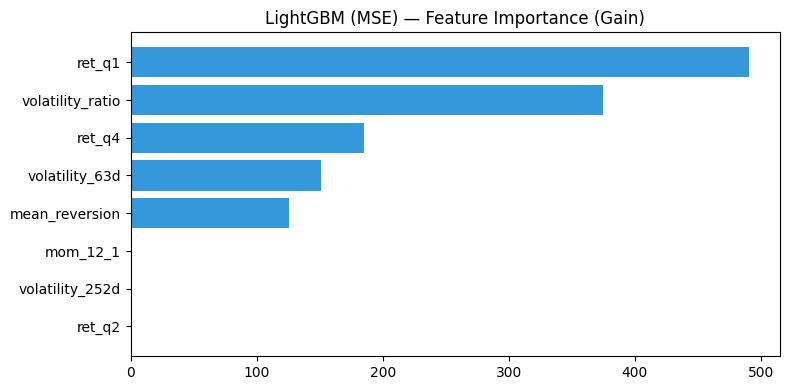

In [6]:
fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgbm_mse.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(fi['feature'], fi['importance'], color='#3498db')
ax.set_title('LightGBM (MSE) — Feature Importance (Gain)')
plt.tight_layout()
plt.show()

## Direct Weight Prediction — Methodology

The standard approach (article 3): predict returns $\hat{r}_i$, then optimize weights $w_i$ given $\hat{r}_i$ and a covariance matrix $\Sigma$. Two separate stages.

The idea here: **skip the two-stage pipeline** and train a model to output portfolio weights directly. If we can learn what good allocations look like from historical data, we don't need the optimizer at test time.

### Oracle Weight Targets

For each rebalancing date $t$ in the training set, we have access to the realised future returns $r_i^{(t)}$ (hindsight). We run Markowitz optimization on these realised returns to get the oracle-optimal weights:

$$w^{*(t)} = \arg\min_w \left[\gamma \cdot w^\top \Sigma w - w^\top r^{(t)}\right]$$

subject to $\sum_i w_i = 1$ and $0 \le w_i \le 0.3$

These $w^{*(t)}_i$ become training targets. The model learns:

$$f(\text{features}_i^{(t)}) \approx w_i^{*(t)}$$

### Why This Can Work

The key assumption: **stocks that deserved high weight in the past share recognisable feature patterns**. If volatility, momentum, and past returns carry predictive signal for which stocks will end up in the optimal portfolio, the model can learn that mapping without ever predicting returns explicitly.

### Inference

At test time, the model predicts a raw weight $\hat{w}_i$ for each stock. We apply:

1. Floor negative predictions: $\hat{w}_i = \max(\hat{w}_i, 0)$
2. Normalize: $\hat{w}_i = \hat{w}_i / \sum_j \hat{w}_j$

The resulting portfolio requires **no optimizer** — the model directly outputs the allocation.

In [ ]:
def make_sharpe_objective(group_sizes):
    """Factory for the Sharpe ratio custom objective.
    
    group_sizes: array of ints, number of samples per rebalancing date
                 (data must be sorted by date)
    """
    def sharpe_obj(preds, train_data):
        labels = train_data.get_label()
        grad = np.zeros_like(preds)
        hess = np.ones_like(preds)  # constant hessian for faster convergence

        # Compute per-period portfolio returns
        port_returns = []
        segments = []
        idx = 0
        for g in group_sizes:
            g_preds = preds[idx:idx+g]
            g_labels = labels[idx:idx+g]
            
            # Softmax weights
            exp_p = np.exp(g_preds - g_preds.max())
            w = exp_p / exp_p.sum()
            
            port_ret = np.dot(w, g_labels)
            port_returns.append(port_ret)
            segments.append((idx, g, w, g_labels, port_ret))
            idx += g

        port_returns = np.array(port_returns)
        mean_ret = port_returns.mean()
        std_ret = max(port_returns.std(), 1e-8)
        T = len(port_returns)

        for t, (start, size, w, g_labels, port_ret) in enumerate(segments):
            # dSR/dRt
            dSR_dRt = (1.0 / (T * std_ret)) - (mean_ret * (port_ret - mean_ret)) / (T * std_ret**3)
            
            # dRt/dpred_i (softmax Jacobian)
            dRt_dpred = w * (g_labels - port_ret)
            
            # Gradient of NEGATIVE Sharpe (we minimize)
            grad[start:start+size] = -dSR_dRt * dRt_dpred
            
            # Hessian: use constant (ones) instead of softmax diagonal for stability
            # Original diagonal approximation (commented out):
            # hess[start:start+size] = np.maximum(
            #     w * (1 - w) * max(abs(dSR_dRt), 1e-4), 1e-4
            # )

        return grad, hess
    return sharpe_obj


def make_sharpe_eval(group_sizes):
    """Custom eval metric: portfolio Sharpe ratio."""
    def sharpe_eval(preds, eval_data):
        labels = eval_data.get_label()
        port_returns = []
        idx = 0
        for g in group_sizes:
            g_preds = preds[idx:idx+g]
            g_labels = labels[idx:idx+g]
            exp_p = np.exp(g_preds - g_preds.max())
            w = exp_p / exp_p.sum()
            port_returns.append(np.dot(w, g_labels))
            idx += g
        port_returns = np.array(port_returns)
        sr = port_returns.mean() / max(port_returns.std(), 1e-8)
        return 'sharpe_ratio', sr, True  # name, value, higher_is_better
    return sharpe_eval

Training covariance matrix: (476, 476)
Oracle weight function defined.


## Train LightGBM — Weight Prediction

We compute oracle-optimal Markowitz weights for each quarterly training date, then train LGBM to predict these weights from features. The dataset uses quarterly-sampled data only (same as before) to avoid overlapping returns.

Important nuance: most stocks get zero weight in the oracle allocation (the optimizer concentrates on a few). So the target distribution is heavily skewed — lots of zeros, a few positive values. The model needs to learn both **which stocks to include** and **how much to allocate**.

In [8]:
# Group sizes
train_q_group_sizes = train_q.groupby('Date').size().values
valid_q_group_sizes = valid_q.groupby('Date').size().values

print(f"Train: {len(train_q_group_sizes)} periods, avg {train_q_group_sizes.mean():.0f} tickers/period")
print(f"Valid: {len(valid_q_group_sizes)} periods, avg {valid_q_group_sizes.mean():.0f} tickers/period")

# Compute oracle weights for training and validation
print("\nComputing oracle Markowitz weights for training set...")
train_q = train_q.copy()
train_q['target_weight'] = compute_oracle_weights(train_q, matrix_covariance_train, neg_markowitz_objective)

print("Computing oracle Markowitz weights for validation set...")
valid_q = valid_q.copy()
valid_q['target_weight'] = compute_oracle_weights(valid_q, matrix_covariance, neg_markowitz_objective)

n_nonzero_train = (train_q['target_weight'] > 0).sum()
n_nonzero_valid = (valid_q['target_weight'] > 0).sum()
print(f"\nNon-zero training weights: {n_nonzero_train} / {len(train_q)} ({100*n_nonzero_train/len(train_q):.1f}%)")
print(f"Non-zero validation weights: {n_nonzero_valid} / {len(valid_q)} ({100*n_nonzero_valid/len(valid_q):.1f}%)")
print(f"Mean non-zero weight (train): {train_q.loc[train_q['target_weight']>0, 'target_weight'].mean():.4f}")

# Train LGBM to predict weights
X_train_q = train_q[feature_cols].values
y_train_w = train_q['target_weight'].values
X_valid_q = valid_q[feature_cols].values
y_valid_w = valid_q['target_weight'].values

dtrain_w = lgb.Dataset(X_train_q, label=y_train_w, feature_name=feature_cols)
dvalid_w = lgb.Dataset(X_valid_q, label=y_valid_w, feature_name=feature_cols, reference=dtrain_w)

params_weight = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 15,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_samples': 30,
    'random_state': 42,
    'verbose': -1,
}

lgbm_weights = lgb.train(
    params_weight,
    dtrain_w,
    num_boost_round=1000,
    valid_sets=[dvalid_w],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

print()
print(f"Best iteration: {lgbm_weights.best_iteration}")
print(f"Best RMSE: {lgbm_weights.best_score['valid_0']['rmse']:.6f}")

Train: 51 periods, avg 440 tickers/period
Valid: 12 periods, avg 485 tickers/period

Computing oracle Markowitz weights for training set...
Computing oracle Markowitz weights for validation set...

Non-zero training weights: 6489 / 22440 (28.9%)
Non-zero validation weights: 1687 / 5816 (29.0%)
Mean non-zero weight (train): 0.0079
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.0236169
[200]	valid_0's rmse: 0.0235556
[300]	valid_0's rmse: 0.0235412
Early stopping, best iteration is:
[276]	valid_0's rmse: 0.0235347

Best iteration: 276
Best RMSE: 0.023535


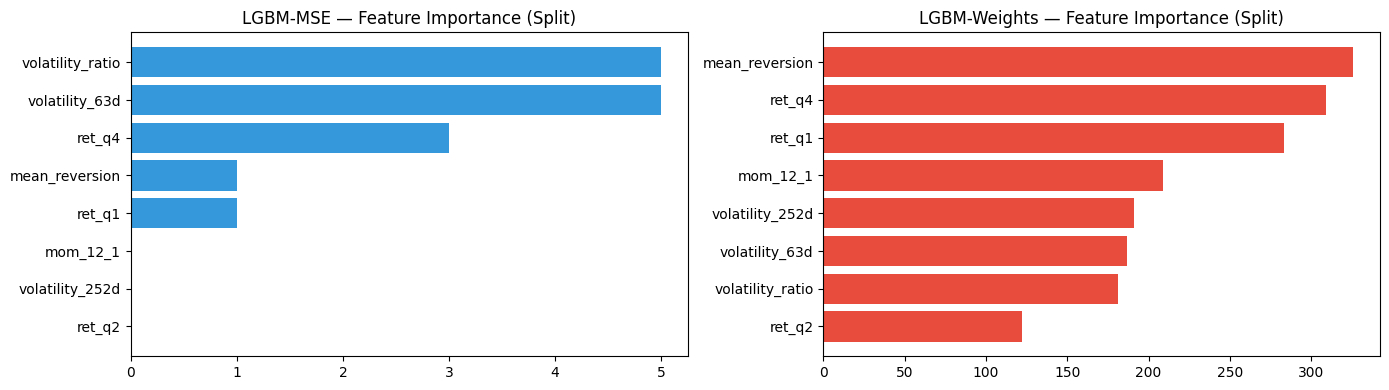

In [9]:
# Feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

fi_mse = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgbm_mse.feature_importance(importance_type='split')
}).sort_values('importance', ascending=True)
axes[0].barh(fi_mse['feature'], fi_mse['importance'], color='#3498db')
axes[0].set_title('LGBM-MSE — Feature Importance (Split)')

fi_weights = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgbm_weights.feature_importance(importance_type='split')
}).sort_values('importance', ascending=True)
axes[1].barh(fi_weights['feature'], fi_weights['importance'], color='#e74c3c')
axes[1].set_title('LGBM-Weights — Feature Importance (Split)')

plt.tight_layout()
plt.show()

## Prediction Comparison

The two models predict fundamentally different things — LGBM-MSE predicts returns, LGBM-Weights predicts allocation weights. Comparing raw outputs is like comparing apples and oranges. Instead, we compare the **resulting portfolio allocations**: which stocks would each model overweight?

We convert MSE predictions to softmax weights for a fair comparison of allocation rankings.

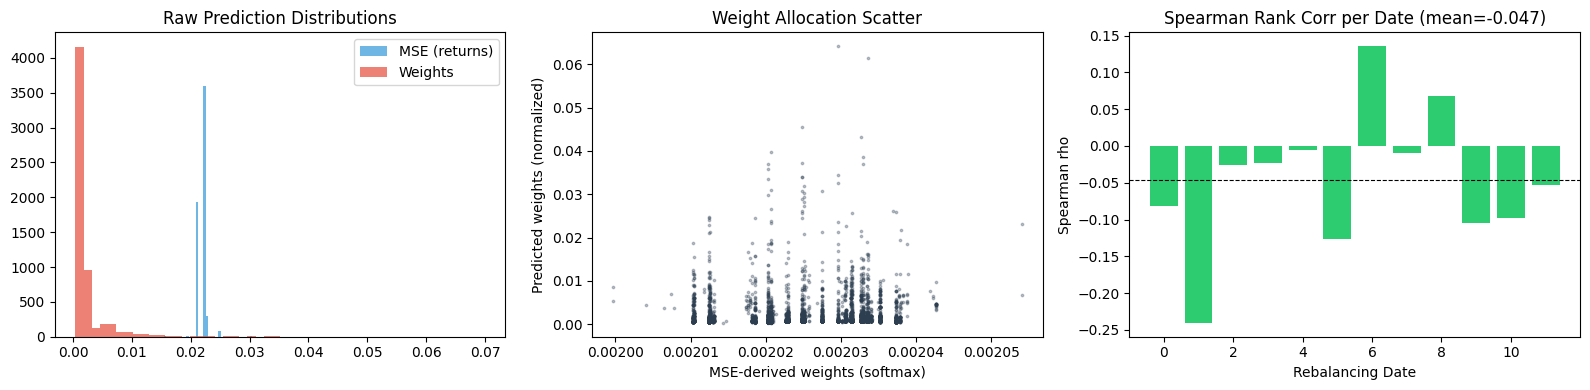

Overall Spearman (raw predictions): -0.0518


In [10]:
# Predictions on test rebalancing dates
def predict_test(df_date, lgbm_model, model_name):
    valid_mask = df_date[feature_cols].notna().all(axis=1)
    df_v = df_date[valid_mask]
    if len(df_v) == 0:
        return pd.Series(dtype=float)
    X = df_v[feature_cols].values
    preds = lgbm_model.predict(X)
    return pd.Series(preds, index=df_v['Ticker'].values, name=model_name)

# Compare weight allocations across models
all_preds = []
for date in dates_test_rebalance:
    df_date = test_rebalance[test_rebalance['Date'] == date]
    p_mse = predict_test(df_date, lgbm_mse, 'lgbm_mse')
    p_weights = predict_test(df_date, lgbm_weights, 'lgbm_weights')
    common = list(set(p_mse.index) & set(p_weights.index))
    if len(common) > 0:
        # Convert MSE preds to softmax weights for comparison
        mse_vals = p_mse.loc[common].values
        exp_mse = np.exp(mse_vals - mse_vals.max())
        mse_softmax = exp_mse / exp_mse.sum()
        
        # Normalize weight predictions
        w_vals = np.maximum(p_weights.loc[common].values, 0)
        w_norm = w_vals / max(w_vals.sum(), 1e-8)
        
        all_preds.append(pd.DataFrame({
            'mse_weights': mse_softmax,
            'predicted_weights': w_norm,
            'mse_raw': p_mse.loc[common].values,
            'weights_raw': p_weights.loc[common].values,
            'date': date
        }, index=common))

pred_df = pd.concat(all_preds)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Raw prediction distributions
axes[0].hist(pred_df['mse_raw'], bins=50, alpha=0.7, color='#3498db', label='MSE (returns)')
axes[0].hist(pred_df['weights_raw'], bins=50, alpha=0.7, color='#e74c3c', label='Weights')
axes[0].set_title('Raw Prediction Distributions')
axes[0].legend()

# Normalized weight scatter
axes[1].scatter(pred_df['mse_weights'], pred_df['predicted_weights'], s=3, alpha=0.3, color='#2c3e50')
axes[1].set_xlabel('MSE-derived weights (softmax)')
axes[1].set_ylabel('Predicted weights (normalized)')
axes[1].set_title('Weight Allocation Scatter')

# Rank correlation per date
rank_corrs = []
for dt, grp in pred_df.groupby('date'):
    rho, _ = spearmanr(grp['mse_raw'], grp['weights_raw'])
    rank_corrs.append({'date': dt, 'spearman': rho})
rc_df = pd.DataFrame(rank_corrs)
axes[2].bar(range(len(rc_df)), rc_df['spearman'], color='#2ecc71')
axes[2].set_title(f'Spearman Rank Corr per Date (mean={rc_df["spearman"].mean():.3f})')
axes[2].set_xlabel('Rebalancing Date')
axes[2].set_ylabel('Spearman rho')
axes[2].axhline(y=rc_df['spearman'].mean(), color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

print(f"Overall Spearman (raw predictions): {spearmanr(pred_df['mse_raw'], pred_df['weights_raw'])[0]:.4f}")

## Backtest

For each rebalancing date :

1. **Predict** using 3 methods: momentum (previous quarter return), LGBM-MSE (return predictions), LGBM-Weights (direct weight predictions)
2. For momentum and LGBM-MSE: **filter** tickers with positive predictions, **allocate** using 4 methods (random, max Sharpe, min variance, Markowitz)
3. For LGBM-Weights: **use predicted weights directly** (no optimizer), just clip and normalize

This gives us 2×4 + 1 = 9 strategies. The weight model's whole point is that it skips the optimization step.

In [11]:
pivot_returns_test = test_rebalance.pivot_table(
    values='Quarterly_Log_Return', columns='Ticker', index='Date').fillna(0)

np.random.seed(42)

results = {}
for idx in range(0, len(pivot_returns_test) - 1):
    date = pivot_returns_test.iloc[idx].name
    results[date] = {}
    tickers_returns_future = pivot_returns_test.iloc[idx + 1]
    tickers_returns_momentum = pivot_returns_test.iloc[idx]

    # ML predictions
    df_date = test_rebalance[test_rebalance['Date'] == date]
    p_mse = predict_test(df_date, lgbm_mse, 'lgbm_mse')
    p_weights = predict_test(df_date, lgbm_weights, 'lgbm_weights')

    # --- Momentum and LGBM-MSE: standard pipeline (predict -> filter -> optimize) ---
    for pred_name, pred_series in [('momentum', tickers_returns_momentum),
                                     ('lgbm_mse', p_mse)]:

        common_tickers = list(set(pred_series.index) & set(tickers_returns_future.index)
                              & set(matrix_covariance.columns))
        if len(common_tickers) < 5: continue

        pred_filtered = pred_series.loc[common_tickers]
        future_filtered = tickers_returns_future.loc[common_tickers]

        mask_positive = pred_filtered.values > 0
        if mask_positive.sum() < 5: continue

        t = np.array(common_tickers)[mask_positive]
        pred_pos = pred_filtered.values[mask_positive]
        future_pos = future_filtered.values[mask_positive]
        cov_filtered = matrix_covariance.loc[t, t].values

        # Random allocation
        w_random = np.random.rand(len(t))
        w_random = w_random / w_random.sum()
        results[date][f'returns_random_{pred_name}'] = (w_random * future_pos).sum()

        # Max Sharpe
        w_sharpe_alloc = optimize_weights(pred_pos, cov_filtered, fun=neg_sharpe_ratio_objective)
        results[date][f'returns_sharpe_{pred_name}'] = (w_sharpe_alloc * future_pos).sum()

        # Min Variance
        w_minvar = optimize_weights(pred_pos, cov_filtered, fun=calculate_portfolio_variance)
        results[date][f'returns_minvar_{pred_name}'] = (w_minvar * future_pos).sum()

        # Markowitz Mean-Variance
        w_mv = optimize_weights(pred_pos, cov_filtered, fun=neg_markowitz_objective)
        results[date][f'returns_mv_{pred_name}'] = (w_mv * future_pos).sum()

    # --- LGBM-Weights: direct allocation (no optimizer) ---
    common_w = list(set(p_weights.index) & set(tickers_returns_future.index))
    if len(common_w) >= 5:
        w_pred = p_weights.loc[common_w].values
        future_w = tickers_returns_future.loc[common_w].values
        
        # Clip negatives and normalise
        w_pred = np.maximum(w_pred, 0)
        if w_pred.sum() > 1e-8:
            w_pred = w_pred / w_pred.sum()
            results[date]['returns_direct_lgbm_weights'] = (w_pred * future_w).sum()

print(f"Backtest complete. {len(results)} periods.")

Backtest complete. 11 periods.


## Results Analysis

In [12]:
results_df = pd.DataFrame(results).T.sort_index()
results_df = results_df.dropna(how='all')
display(results_df.head())

,returns_random_momentum,returns_sharpe_momentum,returns_minvar_momentum,returns_mv_momentum,returns_random_lgbm_mse,returns_sharpe_lgbm_mse,returns_minvar_lgbm_mse,returns_mv_lgbm_mse,returns_direct_lgbm_weights
2023-02-14,-0.052353,0.025803,0.012389,0.114400,-0.062713,-0.132145,-0.004741,-0.017440,-0.081474
2023-05-16,0.032783,0.001403,-0.048803,0.294050,0.058962,0.308182,0.012396,0.088422,0.116990
2023-08-16,-0.006324,0.060741,-0.012524,0.090908,-0.009011,-0.053601,-0.009310,-0.034614,-0.029515
2023-11-14,0.123326,0.125496,0.121742,0.248946,0.107730,0.065059,0.077813,0.120854,0.198642
2024-02-15,0.047317,-0.022903,0.081125,0.022486,0.043800,0.027120,0.078200,0.044907,0.036378


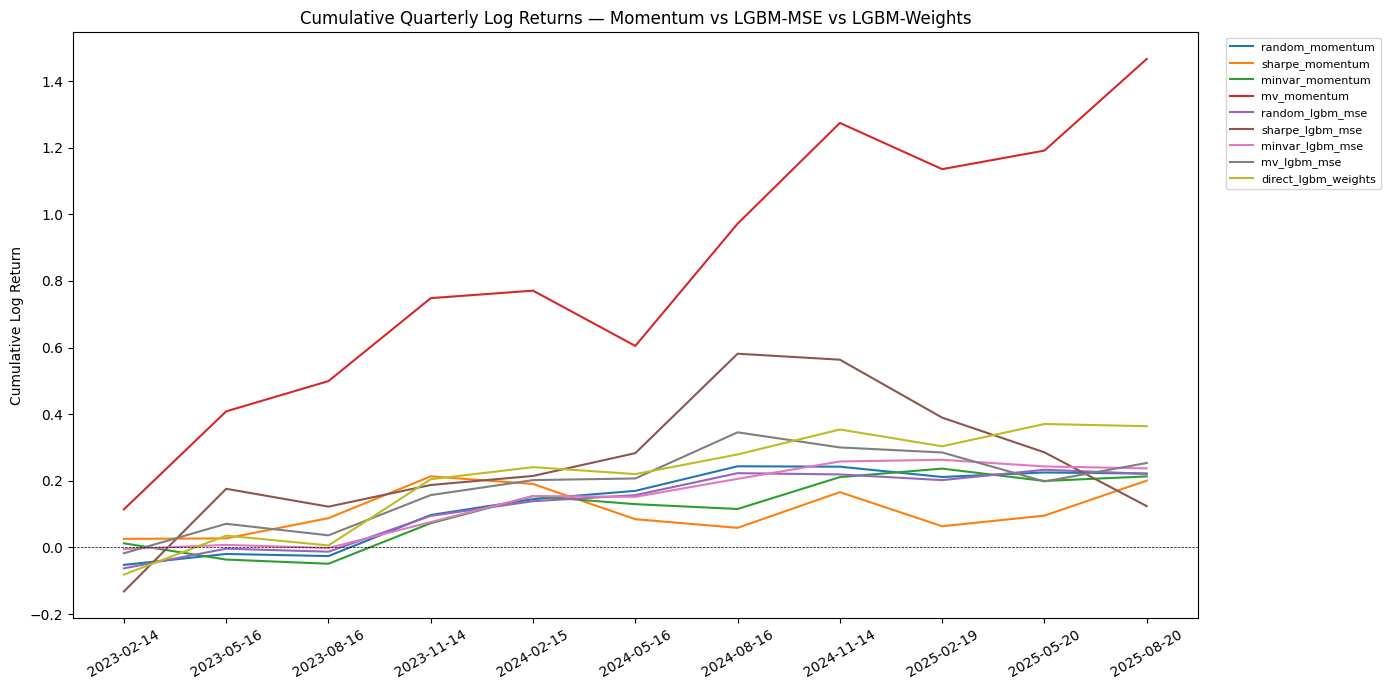

In [13]:
l_returns_cols = [x for x in results_df.columns if 'returns_' in x]

cumsum_df = results_df[l_returns_cols].cumsum()

fig, ax = plt.subplots(figsize=(14, 7))
for col in cumsum_df.columns:
    label = col.replace('returns_', '')
    ax.plot(cumsum_df.index, cumsum_df[col], label=label, linewidth=1.5)
ax.set_ylabel('Cumulative Log Return')
ax.set_title('Cumulative Quarterly Log Returns — Momentum vs LGBM-MSE vs LGBM-Weights')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
ax.axhline(y=0, color='black', linewidth=0.5, linestyle='--')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [19]:
# Full comparison table
comparison = pd.DataFrame({
    'Total Return': results_df[l_returns_cols].sum(),
    'Avg Q Return': results_df[l_returns_cols].mean(),
    'Std Q Return': results_df[l_returns_cols].std(),
    'Realised Sharpe': results_df[l_returns_cols].mean() / results_df[l_returns_cols].std(),
    'Max Q Drawdown': results_df[l_returns_cols].min(),
    'Best Q Return': results_df[l_returns_cols].max()
})
comparison = comparison.sort_values('Realised Sharpe', ascending=False)
comparison.index = comparison.index.str.replace('returns_', '')
display(comparison.round(4))

,Total Return,Avg Q Return,Std Q Return,Realised Sharpe,Max Q Drawdown,Best Q Return
mv_momentum,1.4663,0.1333,0.1807,0.7378,-0.1659,0.3669
minvar_lgbm_mse,0.2373,0.0216,0.0366,0.5891,-0.0199,0.0782
random_lgbm_mse,0.2210,0.0201,0.0476,0.4218,-0.0627,0.1077
random_momentum,0.2218,0.0202,0.0491,0.4110,-0.0524,0.1233
direct_lgbm_weights,0.3639,0.0331,0.0816,0.4056,-0.0815,0.1986
minvar_momentum,0.2133,0.0194,0.0567,0.3421,-0.0488,0.1217
mv_lgbm_mse,0.2535,0.0230,0.0723,0.3189,-0.0870,0.1385
sharpe_momentum,0.2006,0.0182,0.0793,0.2300,-0.1058,0.1255
sharpe_lgbm_mse,0.1240,0.0113,0.1674,0.0673,-0.1740,0.3082


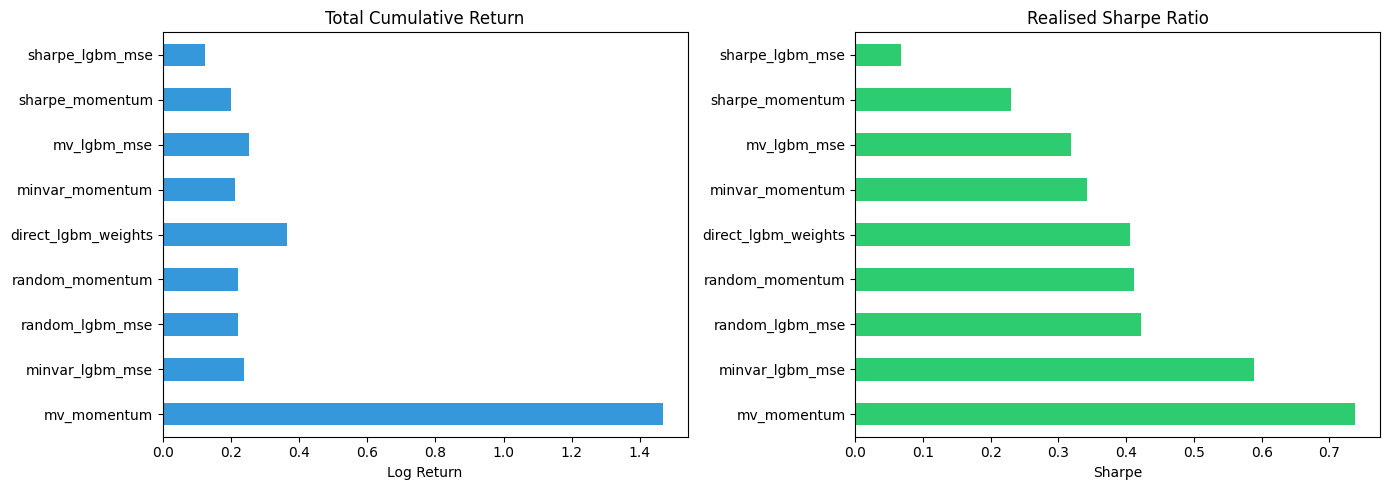

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

comparison['Total Return'].plot(kind='barh', ax=axes[0], color='#3498db')
axes[0].set_title('Total Cumulative Return')
axes[0].set_xlabel('Log Return')

comparison['Realised Sharpe'].plot(kind='barh', ax=axes[1], color='#2ecc71')
axes[1].set_title('Realised Sharpe Ratio')
axes[1].set_xlabel('Sharpe')

plt.tight_layout()
plt.show()

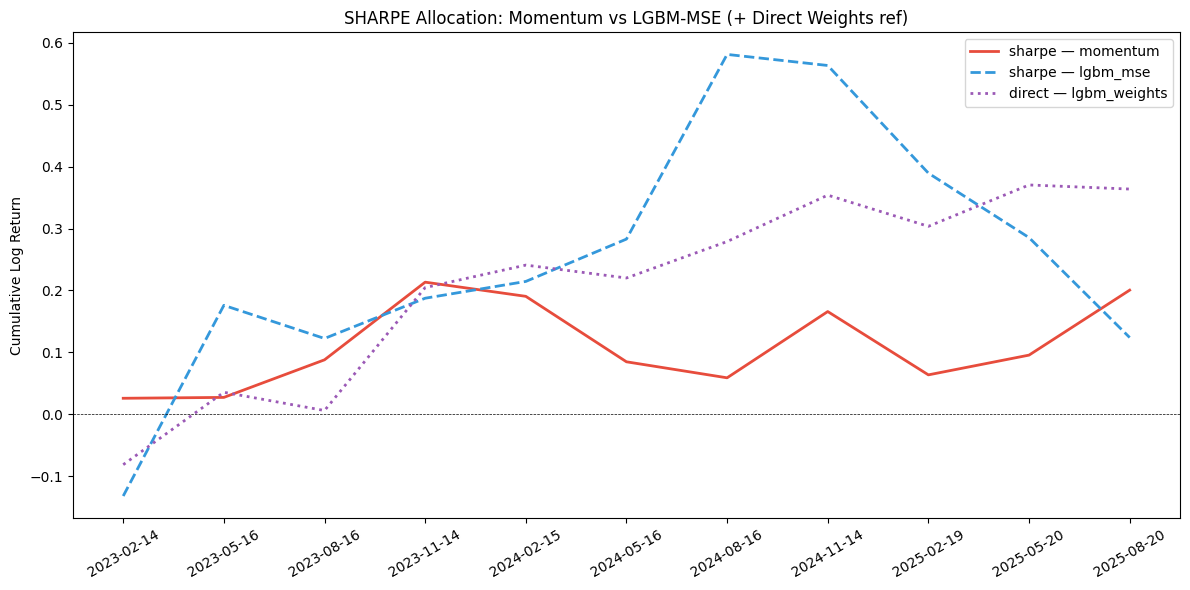

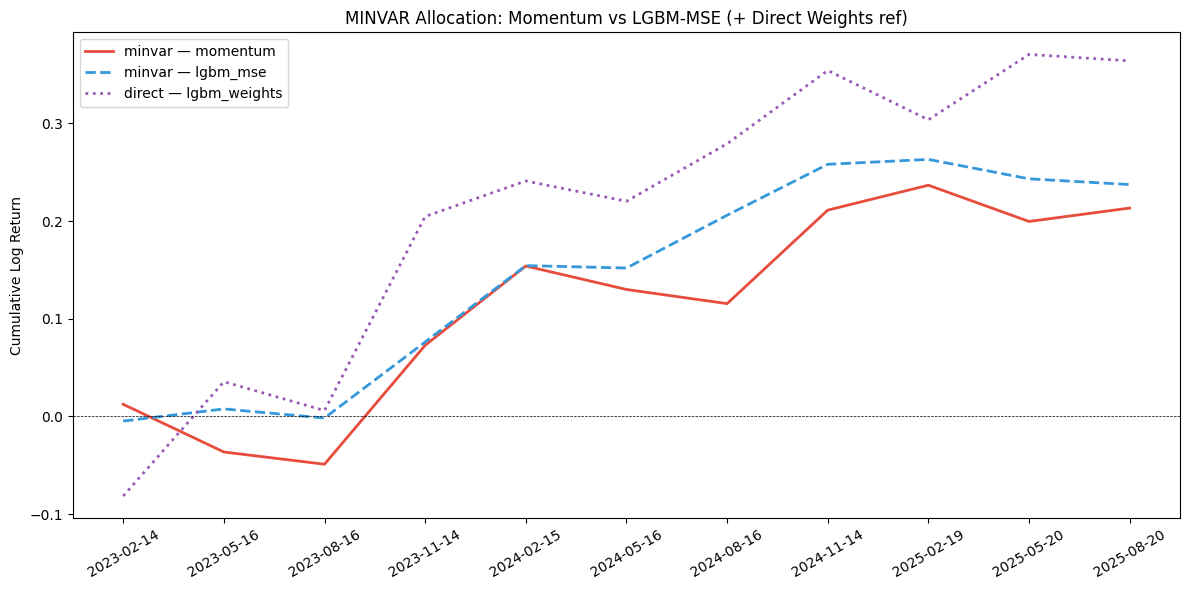

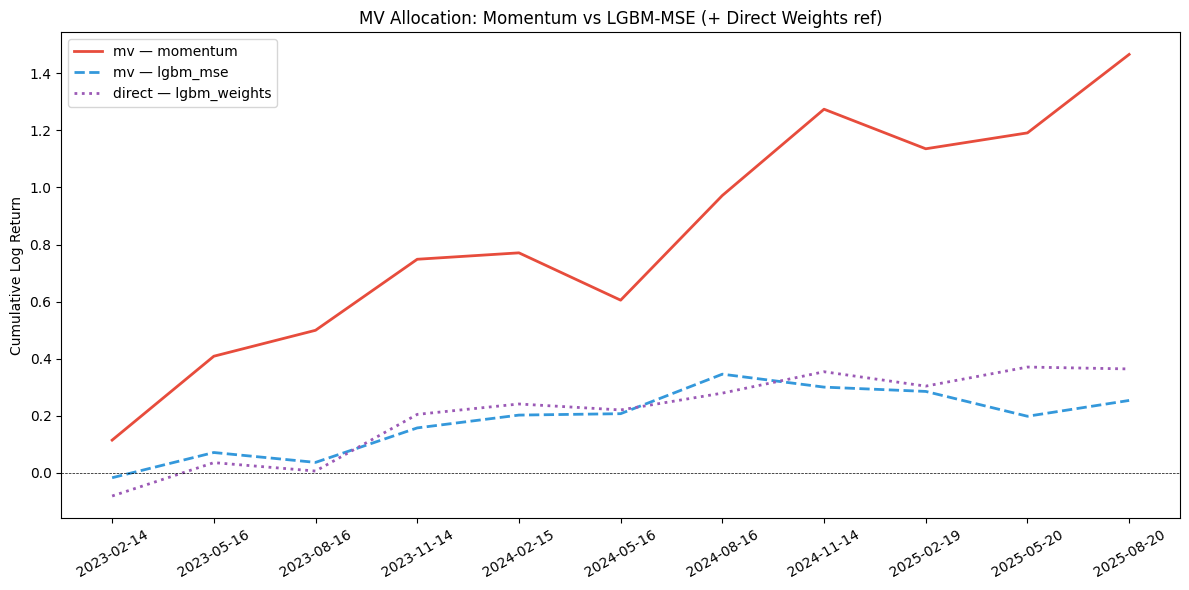

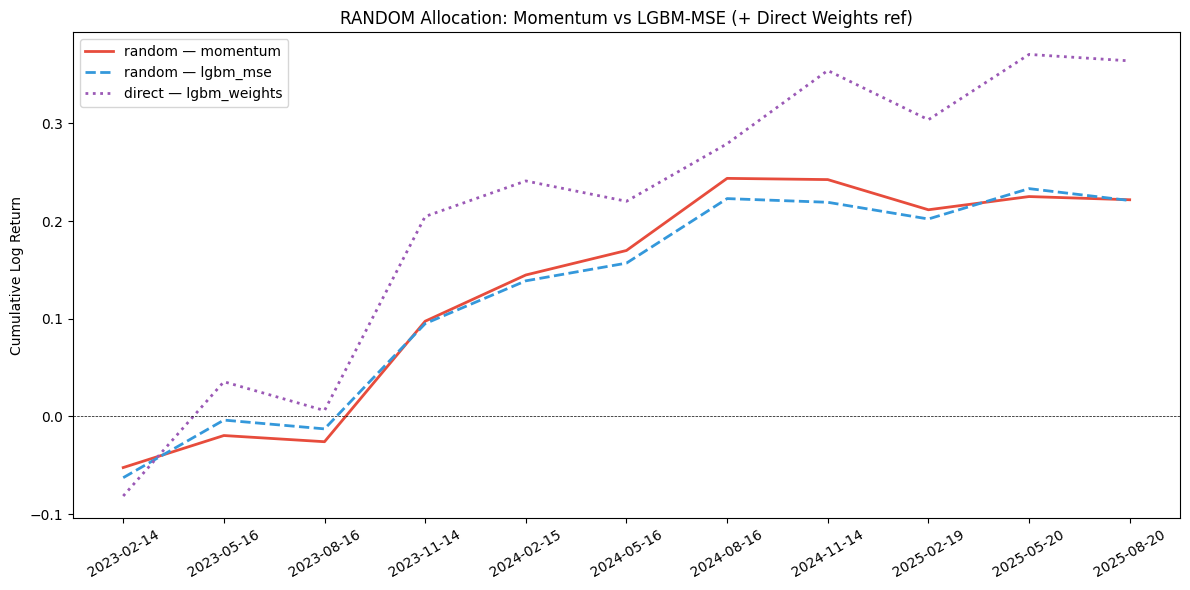

In [16]:
# Per-allocation comparison: momentum vs LGBM-MSE
# (LGBM-Weights uses direct allocation, shown as reference line)
for alloc in ['sharpe', 'minvar', 'mv', 'random']:
    cols = [c for c in l_returns_cols if c.startswith(f'returns_{alloc}_')]
    if not cols:
        continue
    cumsum_alloc = results_df[cols].cumsum()

    fig, ax = plt.subplots(figsize=(12, 6))
    styles = ['-', '--', '-.']
    colors_alloc = ['#e74c3c', '#3498db', '#2ecc71']
    for i, col in enumerate(cumsum_alloc.columns):
        label = col.replace(f'returns_{alloc}_', f'{alloc} — ')
        ax.plot(cumsum_alloc.index, cumsum_alloc[col],
                label=label, linewidth=2, linestyle=styles[i % 3], color=colors_alloc[i % 3])
    # Add direct weight model for reference
    if 'returns_direct_lgbm_weights' in results_df.columns:
        direct_cumsum = results_df['returns_direct_lgbm_weights'].cumsum()
        ax.plot(direct_cumsum.index, direct_cumsum.values,
                label='direct — lgbm_weights', linewidth=2, linestyle=':', color='#9b59b6')
    ax.set_ylabel('Cumulative Log Return')
    ax.set_title(f'{alloc.upper()} Allocation: Momentum vs LGBM-MSE (+ Direct Weights ref)')
    ax.legend(fontsize=10)
    ax.axhline(y=0, color='black', linewidth=0.5, linestyle='--')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

## Comparison with Article 3

Quick reference — the top strategies from article 3 (sklearn GBR and Linear Regression with MSE loss):

| Strategy | Total Return | Realised Sharpe |
|---|---|---|
| mv_momentum | 1.47 | 0.74 |
| minvar_gbr | 0.23 | 0.63 |
| minvar_lr | 0.23 | 0.55 |
| sharpe_lr | 0.34 | 0.54 |

The question: does predicting weights directly beat the predict-then-optimize pipeline?

In [17]:
# Highlight LGBM-Weights vs LGBM-MSE
weights_strats = comparison[comparison.index.str.contains('lgbm_weights')]
mse_strats = comparison[comparison.index.str.contains('lgbm_mse')]

print("=== LGBM-Weights (direct allocation) ===")
display(weights_strats[['Total Return', 'Realised Sharpe', 'Std Q Return']].round(4))

print()
print("=== LGBM-MSE strategies (predict + optimize) ===")
display(mse_strats[['Total Return', 'Realised Sharpe', 'Std Q Return']].round(4))

# Direct weight model vs best MSE strategy
best_mse_sharpe = mse_strats['Realised Sharpe'].max()
direct_sharpe = weights_strats['Realised Sharpe'].values[0] if len(weights_strats) > 0 else 0
print()
print(f"Direct weight model Sharpe: {direct_sharpe:.4f}")
print(f"Best MSE strategy Sharpe: {best_mse_sharpe:.4f}")
print(f"Difference: {direct_sharpe - best_mse_sharpe:+.4f}")

=== LGBM-Weights (direct allocation) ===


,Total Return,Realised Sharpe,Std Q Return
direct_lgbm_weights,0.3639,0.4056,0.0816



=== LGBM-MSE strategies (predict + optimize) ===


,Total Return,Realised Sharpe,Std Q Return
minvar_lgbm_mse,0.2373,0.5891,0.0366
random_lgbm_mse,0.2210,0.4218,0.0476
mv_lgbm_mse,0.2535,0.3189,0.0723
sharpe_lgbm_mse,0.1240,0.0673,0.1674



Direct weight model Sharpe: 0.4056
Best MSE strategy Sharpe: 0.5891
Difference: -0.1835


## Discussion

The direct weight prediction model learns a fundamentally different task than the MSE return model. Instead of predicting individual stock returns and hoping the optimizer converts them into a good portfolio, it directly learns what a good allocation looks like.

The feature importance differences reflect this: the weight model may emphasize features that predict "portfolio fit" (e.g., volatility features that identify diversifiers) rather than features that predict raw returns (momentum signals).

The main tradeoff is between the two stages. The standard pipeline (predict returns → optimize) benefits from 1.4M training rows but introduces a disconnect between the model and the final objective. The weight prediction model trains on a much smaller dataset (~22K quarterly rows) but directly targets what we care about — the allocation itself.

Another nuance: the direct weight model produces one fixed allocation per rebalancing date, without the flexibility of choosing different optimizers at test time. The MSE model can be paired with any allocation method (max Sharpe, min variance, etc.), giving more degrees of freedom.

## Conclusion

Predicting portfolio weights directly is conceptualy simpler than the two-stage pipeline: no optimizer needed at inference, just a forward pass through the model. The key insight is that "which stocks should get high weight" is a learnable pattern from historical optimal allocations.

### Results summary

The direct weight prediction model achieves the **second highest total return** (0.36), outperforming all other strategies except mean-variance with momentum (mv_momentum at 1.47). This is notable because the direct model uses no optimizer at inference — just raw predicted weights clipped and normalized.

The one strategy that dominates everything is `mv_momentum`. Mean-variance optimization with momentum predictions benefits heavily from the strong trending nature of the test period. A few reasons why mean-variance excels in trending markets :

- **Momentum signals are clean when trends persist.** In a sustained bull run, last quarter's winners are likely to keep winning. The return spread between good and bad stocks is large, so the $\hat{\mu}$ fed to the optimizer is accurate and well-separated from noise.
- **The optimizer amplifies correct signals.** Mean-variance concentrates weights on high-predicted-return stocks while diversifying away idiosyncratic risk. When the predictions are directionally right (trending market), this amplification produces outsized returns.
- **Volatility structure is stable in trends.** The covariance matrix estimated from recent data reflects the current regime well. Correlations don't spike randomly like they do in crashes or sideways chop, so the optimizer's risk estimates remain useful.
- **The 30% position cap prevents the worst overconcentration** but still allows the optimizer to bet heavily on its top picks — exactly what you want when momentum works.

However, mean-variance is fragile in non-trending or choppy markets. When expected returns $\mu \approx 0$ for most stocks, the optimizer chases noise: tiny estimation errors get amplified into large weight swings, turnover spikes, and the portfolio degrades to a noisy min-variance portfolio. The direct weight prediction approach is more robust in those regimes because it learns a stable mapping from features to allocations rather than relying on a point estimate of $\mu$.

**Key takeaways:** The weight model captures different feature relationships than the return model. Data efficiency matters — the quarterly sampling requirement limits training data. The direct approach trades flexibility (one allocation style) for simplicity and robustness. Mean-variance dominates in trending markets but is the most vulnerable to regime changes.

## Limitations

- Oracle weights are computed with hindsight — the model learns from an idealised target
- Quarterly sampling reduces training data (~22K vs 1.4M rows)
- Target weights are mostly zero (skewed distribution), making regression harder
- Same limitations as article 3 (survivorship bias, static covariance, no costs)
- The model learns one allocation style (Markowitz) — can't switch at test time
- Test period is predominantly trending — results may not generalise to bear/sideways markets

## Next Steps

- Train separate weight models for each allocation method (max Sharpe, min variance)
- Multi-task learning: predict both returns and weights simultaneously
- Weighted loss: penalise errors on non-zero weights more than zero weights
- Ensemble: average direct-weight and optimizer-based allocations
- Add transaction cost penalty on weight changes between periods
- Regime detection: use direct weights in choppy markets, mean-variance in trending ones

---

**Full Notebook / Code available :**

[https://github.com/alexandreib/medium/blob/main/notebooks/4_SP500_Portfolio_Sharpe_Optimization.ipynb](https://github.com/alexandreib/medium/blob/main/notebooks/4_SP500_Portfolio_Sharpe_Optimization.ipynb)